In [1]:
using LowLevelFEM
import LowLevelFEM as FEM

gmsh.initialize()

In [2]:
using SparseArrays, LinearAlgebra

In [3]:
gmsh.open("body2.geo")

Info    : Reading 'body2.geo'...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.00102129s, CPU 0.00102s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 20%] Meshing surface 2 (Transfinite)
Info    : [ 40%] Meshing surface 3 (Transfinite)
Info    : [ 60%] Meshing surface 4 (Transfinite)
Info    : [ 70%] Meshing surface 5 (Transfinite)
Info    : [ 90%] Meshing surface 6 (Transfinite)
Info    : Done meshing 2D (Wall 0.000506723s, CPU 0.000505s)
Info    : Meshing 3D..

In [4]:
mat = FEM.material("body", E=260, ν=0.3, type=:StVenantKirchhoff)
hooke = FEM.Problem([mat], type=:Solid)
stvenkir = FEM.Problem([mat], type=:Solid)
neohooke = FEM.Problem([mat], type=:Solid)

Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 386)
Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 386)
Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 386)


LowLevelFEM.Problem("body2", :Solid, 3, 3, LowLevelFEM.Material[LowLevelFEM.Material("body", :StVenantKirchhoff, 260.0, 0.3, 7.85e-9, 45.0, 4.2e8, 1.2e-5, 150.0, 100.0, 216.66666666666666)], 1.0, 3321)

In [5]:
supp = FEM.displacementConstraint("left", ux=0, uy=0, uz=0)
suppL = FEM.displacementConstraint("left", ux=0)
suppB = FEM.displacementConstraint("bottom", uy=0)
suppF = FEM.displacementConstraint("front", uz=0)
traction = FEM.load("right", fy=-0.05)
#bodyforce = FEM.load("body", fx=1)

problem = hooke
q = FEM.solveDisplacement(problem, [traction], [supp])
S = FEM.solveStress(problem, q)

LowLevelFEM.TensorField([[-1.5139443207433696; -0.018822139801356885; … ; 0.01081538190407078; -0.005950162160140604;;], [-1.4048575636206837; -0.02417304447173141; … ; 0.0030849916949585166; 0.0038119689375645804;;], [-1.346437355766322; -0.06017414601759974; … ; 0.00027753353056450715; 0.0004345817517508177;;], [-1.273911250959673; -0.06272010507122894; … ; 1.671488044377403e-5; 1.2025334903076335e-5;;], [-1.1994471532665334; -0.06287955724573746; … ; 5.390101143198933e-7; -2.4937059037166698e-6;;], [-1.1245541356926843; -0.06289080916858092; … ; -1.5631444058955962e-9; -4.2124017202160857e-7;;], [-1.049572940082402; -0.06289146527526102; … ; 8.298863846123434e-10; -3.6316665397162495e-8;;], [-0.9745760038342751; -0.06289138604118616; … ; 5.804811263350028e-10; -1.6176479045171277e-9;;], [-0.8995764862984736; -0.0628913457835445; … ; 1.1293188606487092e-10; 1.0507214542876397e-10;;], [-0.8245765613336312; -0.06289133602797037; … ; 1.4410694859634532e-11; 4.356726091003793e-11;;]  …  

In [6]:
u1 = FEM.showDoFResults(problem, q, :uvec)
S1 = FEM.showElementResults(problem, S, :s)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


2

In [7]:
problem = stvenkir
problem = neohooke

LowLevelFEM.Problem("body2", :Solid, 3, 3, LowLevelFEM.Material[LowLevelFEM.Material("body", :StVenantKirchhoff, 260.0, 0.3, 7.85e-9, 45.0, 4.2e8, 1.2e-5, 150.0, 100.0, 216.66666666666666)], 1.0, 3321)

In [8]:
followerLoad = true
loadSteps = 10
firstStep = 0.1
maxIteration = 20
saveSteps = true
saveIterations = false
plotConvergence = true
ε = 1e-5

r0 = FEM.nodePositionVector(problem)
err0 = abs(maximum(r0.a) - minimum(r0.a))
f = FEM.loadVector(problem, [traction])
r = []
r1 = []
push!(r, r0.a)
e = []

for j in range(1, loadSteps)
    fact = j / loadSteps
    err = 1
    i = 0
    while err > ε && i < maxIteration
        i += 1

        Kl = FEM.stiffnessMatrixLinear(problem, r0)
        Knl = FEM.stiffnessMatrixNonLinear(problem, r0)
        if followerLoad == true
            f = FEM.followerLoadVector(problem, r0, [traction])
        end
        fnl = FEM.loadVectorNonLinear(problem, r0)
        K1, f1 = FEM.applyBoundaryConditions(problem, Kl + Knl, fact * f - fnl, [supp])
        q = FEM.solveDisplacement(K1, f1)
        r0 += q
        if saveIterations == true
            push!(r, r0.a)
        end
        err = maximum(abs.(q.a)) / err0
        if plotConvergence == true
            append!(e, err)
        end
    end
    if saveSteps == true
        push!(r, r0.a)
    end
end
if saveIterations == true || saveSteps == true
    n = length(r)
    r1 = zeros(length(r0.a), n)
    for i in 1:n
        r1[:, i] = r[i]
    end
else
    r1 = zeros(length(r0.a), 1)
    r1 = r0
end

In [9]:
r1 = FEM.VectorField([], r1, 1:size(r1, 2), [], size(r1, 2), :u3D)

LowLevelFEM.VectorField(Matrix{Float64}[], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.875 0.8014967071887636 … 0.2236834798236243 0.15315435162446675; 0.875 0.8749970201067293 … 0.8693391373890472 0.8648184156725985], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0], Int64[], 11, :u3D)

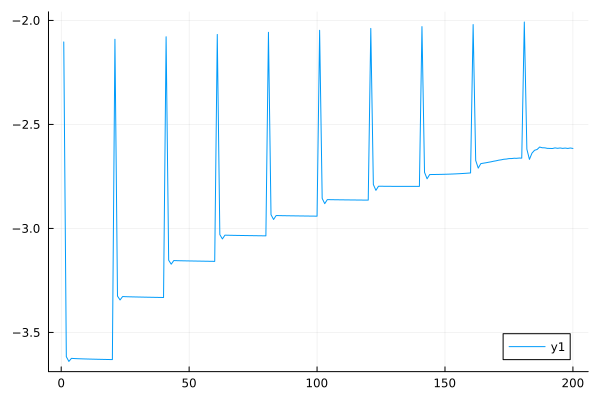

In [10]:
using Plots
plot(log10.(e))

In [11]:
u1 = copy(r1)
r0 = FEM.nodePositionVector(problem)
for i in 1:size(r1.a, 2)
    u1.a[:, i] = r1.a[:, i] - r0.a
end

u2 = FEM.showDoFResults(problem, u1, :uvec, visible=true)

3

In [12]:
#FEM.plotOnPath(problem, "horizontal", u2)
#FEM.plotOnPath(problem, "vertical", u2)

In [13]:
r = FEM.nodePositionVector(problem)
ux(x, y, z) = 0.4x
uy(x, y, z) = 0.5y
uz(x, y, z) = 0.6z
q0 = FEM.field("body", fx=ux, fy=uy, fz=uz)
q = FEM.vectorField(problem, [q0])
F = FEM.deformationGradient(problem, q)

LowLevelFEM.TensorField([[0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;]  …  [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; … ; 0.0; 0.6000000000000001;;], [0.40000000000000213; 0.0; …

In [14]:
reshape(F.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 0.4  0.0  0.0
 0.0  0.5  0.0
 0.0  0.0  0.6

In [15]:
E = (F' * F - FEM.unitTensor(F)) / 2

reshape(E.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -0.42   0.0     0.0
  0.0   -0.375   0.0
  0.0    0.0    -0.32

In [16]:
e = (FEM.unitTensor(F) - inv(F * F')) / 2

reshape(e.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -2.625   0.0   0.0
  0.0    -1.5   0.0
  0.0     0.0  -0.888889

In [17]:
e = inv(F') * E * inv(F)

reshape(e.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -2.625   0.0   0.0
  0.0    -1.5   0.0
  0.0     0.0  -0.888889

In [18]:
U = sqrt(F' * F)

reshape(U.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 0.4  0.0  0.0
 0.0  0.5  0.0
 0.0  0.0  0.6

In [19]:
Ex = 10
νxy = 0.3
λ = Ex * νxy / ((1 + νxy) * (1 - 2νxy))
μ = Ex / (2 * (1 + νxy))
I3 = FEM.unitTensor(F)
iC = inv(F' * F)
J1 = det(F)
SII = μ * (I3 - iC) + λ * log(J1) / J1 * I3

reshape(SII.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -122.128     0.0       0.0
    0.0    -113.474     0.0
    0.0       0.0    -108.773

In [20]:
function probe(A, x, y, z)
    elementTag, elementType, nodeTags, u, v, w = gmsh.model.mesh.getElementByCoordinates(x, y, z, 3, false)
    elementName, dim, order, numNodes::Int64, localNodeCoord, numPrimaryNodes = gmsh.model.mesh.getElementProperties(elementType)
    comp, fun, ori = gmsh.model.mesh.getBasisFunctions(elementType, [u, v, w], "Lagrange")
    SS = [0.0, 0, 0, 0, 0, 0, 0, 0, 0]
    if isa(A, FEM.TensorField)
        ind = findfirst(i -> i == elementTag, SII.numElem)
        for i in range(1, 9)
            SS[i] = fun' * SII.A[ind][i:9:9numNodes, 1]
        end
    elseif isa(A, Matrix)
        for i in range(1, 9)
            SS[i] = fun' * A[9nodeTags.-(9-i), 1]
        end
    end
    return reshape(SS, 3, 3)
end

probe (generic function with 1 method)

In [21]:
SII2 = FEM.elementsToNodes(problem, SII)

LowLevelFEM.TensorField(Matrix{Float64}[], [-122.12805462500343; 0.0; … ; 0.0; -108.77335377030371;;], [0.0], Int64[], 1, :e)

In [22]:
probe(SII2, 0, 0, 0)

3×3 Matrix{Float64}:
 -122.128           5.46571e-14     1.7792e-14
    5.46571e-14  -113.474          -4.55476e-15
    1.7792e-14     -4.55476e-15  -108.773

In [23]:
field = FEM.field("body", f=2)
sc = FEM.ScalarField(problem, [field])

LowLevelFEM.ScalarField([[2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;]  …  [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;]], Matrix{Float64}(undef, 0, 0), Float64[], [473, 474, 475, 476, 477, 478, 479, 480, 481, 482  …  783, 784, 785, 786, 787, 788, 789, 790, 791, 792], 1, :scalarInElements)

In [24]:
I3 = FEM.unitTensor(F)
J = det(F)

LowLevelFEM.ScalarField([[0.12000000000000056; 0.12000000000000056; … ; 0.1199999999999996; 0.11999999999999986;;], [0.12000000000000056; 0.12000000000000056; … ; 0.1199999999999996; 0.11999999999999986;;], [0.12000000000000056; 0.12000000000000056; … ; 0.1199999999999996; 0.11999999999999986;;], [0.12000000000000056; 0.12000000000000056; … ; 0.1199999999999996; 0.11999999999999986;;], [0.12000000000000056; 0.12000000000000056; … ; 0.1199999999999996; 0.11999999999999986;;], [0.12000000000000056; 0.12000000000000056; … ; 0.1199999999999996; 0.11999999999999986;;], [0.12000000000000056; 0.12000000000000056; … ; 0.1199999999999996; 0.11999999999999986;;], [0.12000000000000056; 0.12000000000000056; … ; 0.1199999999999996; 0.11999999999999986;;], [0.12000000000000056; 0.12000000000000056; … ; 0.1199999999999996; 0.11999999999999986;;], [0.12000000000000056; 0.12000000000000056; … ; 0.1199999999999996; 0.11999999999999986;;]  …  [0.12000000000000056; 0.12000000000000056; … ; 0.1199999999999

In [25]:
sc * I3

LowLevelFEM.TensorField([[2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;]  …  [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;]], Matrix{Float64}(undef, 0, 0), [0.0], [473, 474, 475, 476, 477, 478, 479, 480, 481, 482  …  783, 784, 785, 786, 787, 788, 789, 790, 791, 792], 1, :e)

In [26]:
I3 - I3

LowLevelFEM.TensorField([[0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;]  …  [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;]], Matrix{Float64}(undef, 0, 0), [0.0], [473, 474, 475, 476, 477, 478, 479, 480, 481, 482  …  783, 784, 785, 786, 787, 788, 789, 790, 791, 792], 1, :e)

In [27]:
σ = F * SII * F' / det(F)

reshape(σ.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -162.837     0.0       0.0
    0.0    -236.405     0.0
    0.0       0.0    -326.32

In [28]:
J = 0.5 * 0.5 * 0.5
μ / J * (J^(2 / 3) - 1) + λ / J * log(J)

-119.05114807753088

In [29]:
FEM.openPostProcessor()

-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 19700101
Build host    : amdci7.julia.csail.mit.edu
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack LinuxJoystick MathEx[contrib] Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[contrib] Untangle Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.3.8
OCC version   : 7.7.2
Packaged by   : root
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


XOpenIM() failed
XRequest.18: BadValue 0x0


In [30]:
gmsh.finalize()